<a href="https://colab.research.google.com/github/ymuto0302/RW2025/blob/main/transfer_learning_ResNet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ResNet50を利用した転移学習
CIFAR-10 データセットの分類を試みる。

<font color="red">下記のコードを動作させる際，GPU の利用が必須である</font>

## 必要なライブラリのインポート

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import os

# デバイスの設定
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


## データローダーの作成

In [2]:
# データの前処理を定義
def get_transforms():
    # 学習用の変換
    train_transform = transforms.Compose([
        transforms.Resize(224),  # ResNet50の入力サイズに合わせる
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # 検証用の変換
    test_transform = transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    return train_transform, test_transform

# データセットとデータローダーの作成 (CIFAR-10のデータローダーを作成)
def create_dataloaders(batch_size=32):
    train_transform, test_transform = get_transforms()

    # データセットのダウンロードと作成
    train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
    test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)

    # データローダーの作成
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

    return train_loader, test_loader

## 転移学習用の ResNet50 モデル
ここが核心部分！！

In [3]:
# 転移学習用のResNet50モデルを作成
def create_transfer_model(num_classes=10):
    # 1. 事前学習済みモデルを読み込む
    model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)

    # 2. 一旦，全ての層を凍結する
    for param in model.parameters():
        param.requires_grad = False

    # 3. 最終分類層を新しいタスクに合わせて変更
    num_feature = model.fc.in_features
    model.fc = nn.Linear(num_feature, num_classes)

    # 4. 新しく追加した層のパラメータは学習対象にする
    for param in model.fc.parameters():
        param.requires_grad = True

    return model

## モデルの学習
（注意） Colab の T4 GPU を使っても約 30分の実行時間を要する。



In [4]:
# 学習関数
def train_model(model, train_loader, test_loader, num_epochs=30, learning_rate=0.001):
    # 損失関数と最適化アルゴリズムの定義
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # 学習履歴を記録するリスト
    train_losses = []
    train_accuracies = []
    test_losses = []
    test_accuracies = []

    for epoch in range(num_epochs):
        # 学習フェーズ
        model.train()
        running_loss = 0.0
        correct_predictions = 0
        total_samples = 0

        for inputs, labels in tqdm(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            # 勾配をゼロにリセット
            optimizer.zero_grad()

            # 順伝播
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # 逆伝播と最適化
            loss.backward()
            optimizer.step()

            # 統計情報の更新
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_samples += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()

        # エポックの学習結果を記録
        epoch_train_loss = running_loss / len(train_loader)
        epoch_train_acc = 100. * correct_predictions / total_samples
        train_losses.append(epoch_train_loss)
        train_accuracies.append(epoch_train_acc)

        # 検証フェーズ
        model.eval()
        test_loss = 0.0
        test_correct = 0
        test_total = 0

        with torch.no_grad():
            for inputs, labels in tqdm(test_loader):
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                test_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                test_total += labels.size(0)
                test_correct += (predicted == labels).sum().item()

        # エポックの検証結果を記録
        epoch_test_loss = test_loss / len(test_loader)
        epoch_test_acc = 100. * test_correct / test_total
        test_losses.append(epoch_test_loss)
        test_accuracies.append(epoch_test_acc)

        # エポック結果の表示
        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'  Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.2f}%')
        print(f'  Test Loss: {epoch_test_loss:.4f}, Test Acc: {epoch_test_acc:.2f}%')
        print('-' * 50)

    # 学習履歴を返す
    history = {
        'train_loss': train_losses,
        'train_acc': train_accuracies,
        'test_loss': test_losses,
        'test_acc': test_accuracies
    }

    return history

# === 以下，実行部分 ===
# ハイパーパラメータ
batch_size = 64 # バッチサイズ
num_epochs = 10 # エポック数
learning_rate = 0.001 # 学習率
num_classes = 10 # 取り組むタスクのクラス数

# データローダーの作成
train_loader, test_loader = create_dataloaders(batch_size)

# モデルの作成
model = create_transfer_model(num_classes)
model = model.to(device)

# 学習の実行
history = train_model(
    model, train_loader, test_loader,
    num_epochs=num_epochs, learning_rate=learning_rate
)

100%|██████████| 157/157 [00:32<00:00,  4.80it/s]


Epoch 1/10:
  Train Loss: 0.7625, Train Acc: 74.74%
  Test Loss: 0.5923, Test Acc: 79.75%
--------------------------------------------------


100%|██████████| 157/157 [00:32<00:00,  4.78it/s]


Epoch 2/10:
  Train Loss: 0.5990, Train Acc: 79.42%
  Test Loss: 0.5511, Test Acc: 80.79%
--------------------------------------------------


100%|██████████| 157/157 [00:32<00:00,  4.77it/s]


Epoch 3/10:
  Train Loss: 0.5685, Train Acc: 80.20%
  Test Loss: 0.5770, Test Acc: 80.48%
--------------------------------------------------


100%|██████████| 157/157 [00:32<00:00,  4.82it/s]


Epoch 4/10:
  Train Loss: 0.5434, Train Acc: 81.18%
  Test Loss: 0.5357, Test Acc: 81.58%
--------------------------------------------------


100%|██████████| 157/157 [00:32<00:00,  4.82it/s]


Epoch 5/10:
  Train Loss: 0.5328, Train Acc: 81.49%
  Test Loss: 0.5360, Test Acc: 81.74%
--------------------------------------------------


100%|██████████| 157/157 [00:32<00:00,  4.83it/s]


Epoch 6/10:
  Train Loss: 0.5192, Train Acc: 82.01%
  Test Loss: 0.5320, Test Acc: 81.75%
--------------------------------------------------


100%|██████████| 157/157 [00:32<00:00,  4.80it/s]


Epoch 7/10:
  Train Loss: 0.5175, Train Acc: 82.03%
  Test Loss: 0.5272, Test Acc: 82.11%
--------------------------------------------------


100%|██████████| 157/157 [00:32<00:00,  4.78it/s]


Epoch 8/10:
  Train Loss: 0.5062, Train Acc: 82.34%
  Test Loss: 0.5143, Test Acc: 82.54%
--------------------------------------------------


100%|██████████| 157/157 [00:32<00:00,  4.77it/s]


Epoch 9/10:
  Train Loss: 0.4933, Train Acc: 82.81%
  Test Loss: 0.5213, Test Acc: 82.02%
--------------------------------------------------


100%|██████████| 157/157 [00:32<00:00,  4.82it/s]

Epoch 10/10:
  Train Loss: 0.4903, Train Acc: 83.04%
  Test Loss: 0.4824, Test Acc: 83.42%
--------------------------------------------------


## 学習曲線

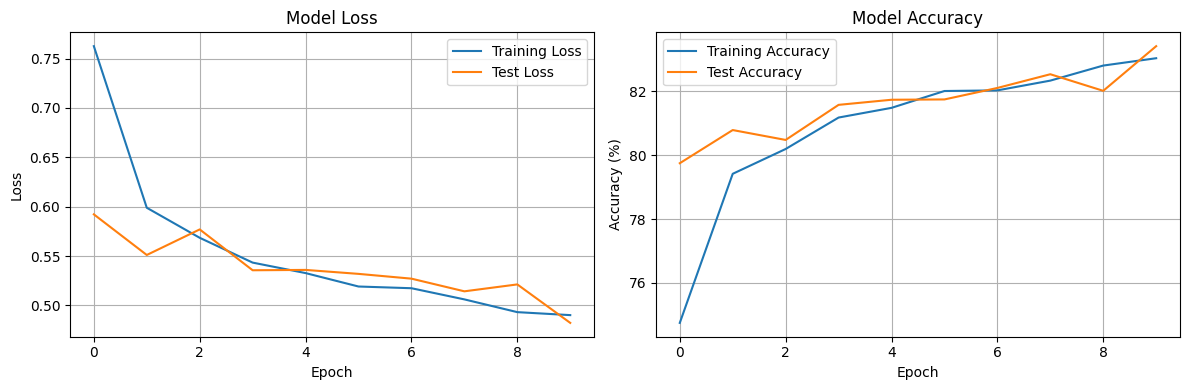

In [6]:
# 学習結果の可視化
def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    # 損失の推移
    ax1.plot(history['train_loss'], label='Training Loss')
    ax1.plot(history['test_loss'], label='Test Loss')
    ax1.set_title('Model Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)

    # 精度の推移
    ax2.plot(history['train_acc'], label='Training Accuracy')
    ax2.plot(history['test_acc'], label='Test Accuracy')
    ax2.set_title('Model Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

# 学習結果の可視化
plot_training_history(history)

## テスト（モデルの評価）
最終的なモデルに対して，改めてテストーデータを与えてモデルの性能を評価する。

In [7]:
# テスト関数
def test_model(model, test_loader):
    # CIFAR-10のクラス名
    cifar10_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

    # モデルの性能を評価
    model.eval()
    correct = 0
    total = 0
    class_correct = [0.0] * 10 # list(0. for i in range(10))
    class_total = [0.0] * 10 # list(0. for i in range(10))

    with torch.no_grad():
        for inputs, labels in tqdm(test_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # クラス別の精度計算
            c = (predicted == labels).squeeze()
            for i in range(labels.size(0)):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1

    # 全体の精度
    overall_acc = 100. * correct / total
    print(f'Overall Test Accuracy: {overall_acc:.2f}%')

    # クラス別の精度
    print("\nClass-wise Accuracy:")
    for i in range(10):
        if class_total[i] > 0:
            acc = 100 * class_correct[i] / class_total[i]
            print(f'{cifar10_classes[i]}: {acc:.2f}%')

# テストを実行
test_model(model, test_loader)

100%|██████████| 157/157 [00:34<00:00,  4.60it/s]

Overall Test Accuracy: 83.42%

Class-wise Accuracy:
airplane: 78.90%
automobile: 89.60%
bird: 79.50%
cat: 70.50%
deer: 78.00%
dog: 81.60%
frog: 88.60%
horse: 87.10%
ship: 91.60%
truck: 88.80%


## (参考) モデルの保存
大規模モデルを転移学習するのに相応の時間を要する。再学習するのはコスト高であるため，通常，モデルを保存する。

In [8]:
# モデルの保存
def save_model(model, filepath):
    torch.save(model.state_dict(), filepath)
    print(f"Model saved to {filepath}")

# モデルの保存
save_model(model, 'resnet50_cifar10_transfer.pth')


Model saved to resnet50_cifar10_transfer.pth
